In [1]:
import pandas as pd 
import numpy as np
import glob
import os
import json
import matplotlib.pyplot as plt



import torch
import torch.nn as nn
import torch.optim as optim
import cv2 as cv

from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from PIL import Image
from IPython.display import clear_output

In [29]:
initial_size = 10496
scale = 4
orig = Image.open('original.tiff')
original = np.array(orig)


orig_resized = orig.resize((initial_size // scale, initial_size // scale))
original_resized = np.array(orig_resized)

In [30]:
def crop_angle(angle):
    angle = angle % 90
    if angle > 45:
        return 90 - angle
    else:
        return angle

In [38]:
def rotated_crop(orig_image, scale, center, deg_angle):
    cc = np.array([center[0], center[1]])
        
    x_scaled, y_scaled = center[1] // scale, center[0] // scale
    rad_angle_ = np.deg2rad(crop_angle(deg_angle))
    crop_size_scaled = int(round(
        (np.cos(rad_angle_) + np.sin(rad_angle_)) * 1024 / scale
    ))
    
    half = crop_size_scaled // 2
    
    scaled_size = orig_image.shape[0]
    
    s1, s2 = max(x_scaled - half, 0), min(x_scaled + half, scaled_size)
    s3, s4 = max(y_scaled - half, 0), min(y_scaled + half, scaled_size)

    cropped_image = orig_image[s1:s2, s3:s4]
    M = cv.getRotationMatrix2D((half, half), deg_angle, 1.0)

    rotated = cv.warpAffine(cropped_image, M, (s2 - s1, s4 - s3))
    cX, cY = half, half
    half_s = 512 // scale

    # generated coordinates
    M_hat = M[:, :2].T
    lt = (cc + M_hat @ np.array([-512, -512]))  # left top
    rb = (cc + M_hat @ np.array([512, 512]))    # right bottom

    return np.array(lt.tolist() + rb.tolist() + [np.deg2rad(deg_angle)]), rotated[cX - half_s: cX + half_s, cY - half_s: cY + half_s]



def get_rotated_image(orig_image, center, angle, scale):
    x, y = center[1] // scale, center[0] // scale
    rad_angle = np.deg2rad(crop_angle(angle))
    
    crop_size = int(round(
        1024 * (np.cos(rad_angle) + np.sin(rad_angle))
    )) // scale
    
    half = crop_size // 2
    cX, cY = half, half
    half_s = 512 // scale
    
    
    cropped_image = orig_image[x - half:x + half,y - half: y + half]
    M = cv.getRotationMatrix2D((half, half), angle, 1.0)
    rotated = cv.warpAffine(cropped_image, M, (crop_size, crop_size))
    cX, cY = half, half
    return rotated, rotated[cX - half_s: cX + half_s, cY - half_s: cY + half_s]


def read_img_data(path):
    with open(path, 'r') as f:
        obj = json.load(f)
        
    res_pos = (np.array(obj['left_top']) + \
    np.array(obj['right_bottom']) + \
    np.array(obj['left_bottom']) + \
    np.array(obj['right_top'])) / 4


    res_pos = np.round(res_pos).astype(np.int32)
    return obj, res_pos, obj['angle']

In [39]:
path = 'train/json/1.json'

obj, center, angle = read_img_data(path)

In [40]:
obj, center, angle

({'left_top': [8533, 2184],
  'right_top': [9501, 1851],
  'left_bottom': [8866, 3152],
  'right_bottom': [9834, 2819],
  'angle': 341},
 array([9184, 2502], dtype=int32),
 341)

In [41]:
labels, rotated_cropped = rotated_crop(original_resized, scale, center, angle)

In [42]:
print(labels.astype(np.int32))

[8533 2184 9834 2819    5]


In [43]:
rotated_cropped.shape

(256, 256, 3)

[8.53320359e+03 2.18458538e+03 9.83479641e+03 2.81941462e+03
 5.95157275e+00]


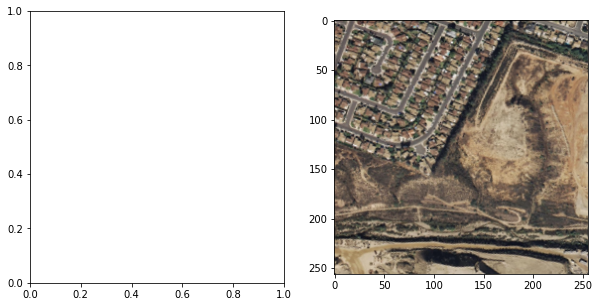

In [44]:
labels, rotated_cropped = rotated_crop(original_resized, scale, center, angle)
print(labels)



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(rotated)
ax[1].imshow(rotated_cropped)
plt.show()

In [69]:
while True:
    angle = np.random.randint(360)
    rad_angle = np.deg2rad(crop_angle(angle))
    s, c = np.sin(rad_angle), np.cos(rad_angle)
    size = int(round(1024 * (s + c)))
    s_less = size // 2

    x = np.random.randint(s_less + 1, 10496 - s_less - 1)
    y = np.random.randint(s_less + 1, 10496 - s_less - 1)

    labels, image = rotated_crop(original_resized, scale, (x, y), angle)

    labels[:4] = labels[:4] / 10496
    labels[4] = labels[4] / (2 * np.pi)
    if labels.min() < 0. or labels.max() > 1.:
        print(labels)
        print((x, y), angle, s_less, size)
        break

In [10]:
tf_totensor = transforms.ToTensor()
tf_color = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)

In [21]:
import imgaug.augmenters as iaa
aug = iaa.Clouds()


from core.utils import Cutout
cutout = Cutout(50, 1.)

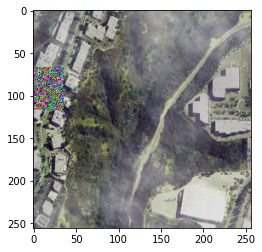

In [48]:
im_clouds = aug.augment_image(rotated_cropped)
augmented = tf_color(cutout(tf_totensor(im_clouds)))
plt.imshow(augmented.permute(1, 2, 0))

In [161]:
np.sin(np.random.uniform(360))

-0.795115103786555

In [177]:
np.random.random()

0.6379649239504563

In [179]:
s = int(round(np.sin(np.deg2rad(45)) * 1024 * 2))
s

1448

In [223]:
import torchvision.transforms as tf

In [241]:
img = np.random.randint(256, size=(5, 5, 3)).astype(np.uint8)


transformed = tf.ToTensor()(img)
transformed
tf.Normalize(mean=[0.5, 0.5, 0.5], std=[1., 1., 1.])(transformed)

tensor([[[ 0.2490, -0.3000, -0.4333, -0.3588,  0.4255],
         [ 0.3431, -0.3510, -0.3863, -0.4255,  0.4882],
         [-0.3314,  0.0373,  0.2686, -0.4725, -0.3824],
         [ 0.2882,  0.3000, -0.3706, -0.4176,  0.3275],
         [ 0.2020,  0.3627,  0.4843,  0.0725, -0.4843]],

        [[-0.2059,  0.1627, -0.3431,  0.0176, -0.1196],
         [-0.2373,  0.3706,  0.2961,  0.4765,  0.4333],
         [-0.1392,  0.0098, -0.2216, -0.0490, -0.3588],
         [-0.2569, -0.0647, -0.2647, -0.3314, -0.0373],
         [-0.0647,  0.4647, -0.3863, -0.4294,  0.1941]],

        [[-0.1745,  0.0255, -0.3784, -0.3941,  0.4765],
         [-0.4529, -0.4843, -0.4490, -0.3980, -0.0882],
         [ 0.3667,  0.1353, -0.2765,  0.3157, -0.3431],
         [ 0.3941, -0.4059, -0.3314, -0.0569,  0.2647],
         [ 0.3000, -0.1588, -0.4098, -0.2176, -0.1000]]])